
In this section, calcium fluxes in a compartmentalized cell were modelled. Calcium can be present in the cytosol ($Ca_{cyt}$), bound to calcium binding proteins residing in the cytosol ($CaPr$), the Endoplasmic Reticulum (ER) ($Ca_{ER}$) as well as the mitochondria ($Ca_m$). Fluxes between these compartments occur, leading to a an exchange of calcium. The overall setup of the system is shown in Figure X.
![title](Scheme.png)
Figure X: Calcium fluxes within a cell.

Different formulas are used to describe this system.
The total calcium concentration ($Ca_{tot}$) can be defined as:

$Ca_{tot} = Ca_{cyt} + \frac{\rho_{ER}}{\beta_{ER}} Ca_{ER}+\frac{\rho_{m}}{\beta_{m}} Ca_{m}+CaPr$

The total amount of the calcium binding protein ($Pr_{tot}$) in its bound ($CaPr$) or unbound ($Pr$) form is defined as:

$Pr_{tot} = Pr + CaPr$

To describe the rate of change of calcium concentrations in the different compartments the following formulas can be used:

$\frac{dCa_{cyt}}{dt} = J_{ch} + J_{leak} - J_{pump} + J_{out} - J_{in} + k_- CaPr - k_+ Ca_{cyt}Pr$

$\frac{dCa_{ER}}{dt} = \frac{\beta_{ER}}{\rho_{ER}}(J_{pump} - J_{ch} - J_{leak})$

$\frac{dCa_{m}}{dt} = \frac{\beta_{m}}{\rho_{m}}(J_{in} - J_{out})$

Where the fluxes ($J$) are defined as:

$J_{pump} = k_{pump}Ca_{cyt}$

$J_{ch} = k_{ch}\frac{Ca_{cyt}^2}{K_1^2+Ca_{cyt}^2}(Ca_{ER}-Ca_{cyt})$

$J_{leak} = k_{leak}(Ca_{ER} - Ca_{cyt})$

$J_{in} = k_{in}\frac{Ca_{cyt}^8}{K_2^8+Ca_{cyt}^8}$

$J_{out} = (k_{out}\frac{Ca_{cyt}^2}{K_3^2+Ca_{cyt}^2}+k_m)Ca_{m}$



$\beta_{compartment}$ represents the concentration of calcium in the compartment relative to the cytosol, while $\rho_{compartment}$ is the ratio of the compartments volume compared to the cytosol.

$k_- CaPr$ represents the dissociation of calicum bound proteins into free calcium and unbound proteins. $k_+ Ca_{cyt}Pr$ is the forward reaction of calcium residing in thy cytosol and free proteins to $CaPr$.

$J_{pump}$ is the outflux from the cytosol into the ER via ion pumps. It depends on the rate of the ion pump (k_{pump}) as well as the current concentration of cytosolic calcium. Higher calcium concentration, as well as a more active pump lead to a higher $J_{pump}$.

$J_{ch}$ defines the flux from the ER into the cystosol via calcium channels. $k_{ch}\frac{Ca_{cyt}^2}{K_1^2+Ca_{cyt}^2}$ is the maximal rate of the calcium channel ($k_{ch}$) scaled by a Hill term that takes into account the affinity of the channel for calcium ($K_1$) and the current calcium concentration in the cytosol, together with a Hill coefficient of 2. The direction of the flux, as well as the extend is further modified by the difference in $Ca_{ER}$ and $Ca_{cyt}$. Since transport through the channels is passive, it will seak to establish equilibrium, by producing a flux from the compartment with the higher concentration to the one with the lower one. A bigger gradient between the two of them lead to a stronger flux.

$J_{leak}$ describes the leakage of calcium ions through the membrane of the ER into the cytosol. It depends on the maximum rate at which ions can pass trough the membrane ($k_{leak}$) and analogically to $J_{ch}$ the gradient between $Ca_{ER}$ and $Ca_{cyt}$.

$J_{in}$ is defined as the influx of $Ca^{2+}$ ions from the cytosol to the mitochondria. It is decribes by a the maximal inflow rate $k_{in}$ and a Hill term ($\frac{Ca_{cyt}^8}{K_2^8+Ca_{cyt}^8}$), that takes into account the max, the the affinity parameter $K_{2}, as well as cytosolic calcium concentrations, and has a hill coefficient of 8.

Lastly the formula of $J_{out}$ contains $k_m$ as a term to describe leakage from the mitochondria to the cytosol, as well as $k_{out}\frac{Ca_{cyt}^2}{K_3^2+Ca_{cyt}^2}$ as the product of maximal non-leakage outflow and a Hill term with the Hill coefficient 2. The sum of these two terms is scaled by the current concentration of mitochondrial calcium.

The fact that both $J_{in}$ and $J_{out}$ contain Hill terms, indicates that these fluxes are partly mediated by proteins, like ion channels or ion pumps, although these are not indicated in the scheme. These mitochondrial membrane proteins, as well as the ion channels situated in the ER membrane appear to consist of several subunits, that display cooperativity. The Hill coefficients indicate that the ER ion channel, and the proteins mediating mitochondrial outflux might consist of two cooperating units, while the proteins mediating the influx of calcium into the mitochondria might consist of eight such subunits.

In [35]:
# Basic Imports
from __future__ import division
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import pandas as pd
import math
import random
import copy
from scipy.integrate import odeint
from ipywidgets import interact, interactive, fixed
from IPython.display import clear_output, display, HTML
import sympy.solvers.ode
from sympy import *

If a genetic mutation would occur that would prevent the transscription and translation of the gene encoding the calcium channels, or would lead to misfolded and therefore inactive channels, the system would display very different dynamics.
The $Ca^{2+}$ channels allow a passive transport of calcium ions through the membrane of the ER. As long as the channels are functional and open, ions will flow from the higher to the lower concentration. In the model present, $k_{ch}$ is set to 4100 $s^{-1}$, meaning that high numbers of ions can pass trough the channel if the gradient between ER and cystol is high. If the channels would be inactivated, no channel mediated flow would be possible anymore. Therefore $J_{ch}$ would be set to 0 causing the formulas of to change respecitively. This yields:
$\frac{dCa_{cyt}}{dt} = J_{leak} - J_{pump} + J_{out} - J_{in} + k_- CaPr - k_+ Ca_{cyt}Pr$

$\frac{dCa_{ER}}{dt} = \frac{\beta_{ER}}{\rho_{ER}}(J_{pump} - J_{leak})$

$\frac{dCa_{m}}{dt} = \frac{\beta_{m}}{\rho_{m}}(J_{in} - J_{out})$

In [36]:
def fluxPump(k_pump,Ca_cyt):
    return k_pump*Ca_cyt

def fluxLeak(k_leak, Ca_ER, Ca_cyt):
    return k_leak*(Ca_ER - Ca_cyt)

def fluxIn(k_in, K2, Ca_cyt):
    return k_in*(Ca_cyt**8/(K2**8 + Ca_cyt**8))

def fluxOut(k_out, K3, Ca_cyt, km, Ca_m):
    return Ca_m*(k_out*(Ca_cyt**2 / (K3**2 + Ca_cyt**2))+km)

def calcCaPr(Ca_tot, Ca_cyt, Ca_ER, Ca_m, p_ER, p_m, b_ER, b_m):
    return Ca_tot - (Ca_ER*(p_ER/b_ER)) - (Ca_m*(p_m/b_m)) - Ca_cyt

def calcPr(Pr_tot, CaPr):
    return Pr_tot - CaPr

# Differential equations

def dCa_cyt(J_leak, J_pump, J_in, J_out, k_minus, CaPr, k_plus, Ca_cyt, Pr):
    return J_leak - J_pump + J_out - J_in + (k_minus*CaPr) - (k_plus*Ca_cyt*Pr)

def dCa_ER(beta_ER, rho_ER, J_pump, J_leak):
    return (beta_ER/rho_ER)*(J_pump - J_leak)

def dCa_m(beat_m, rho_m, J_in, J_out):
    return (beta_m/rho_m)*(J_in-J_out)    

# System of Ordinary Differential Equation

def ODE_Calcium_Sys(y0, t, Ca_tot, Pr_tot, p_ER, p_m, b_ER, b_m, k_pump, k_leak, k_in, k_out, k_m, k_plus, k_minus, K1,K2,K3):
    '''This function defines the system of ODES which controls the levels of calcium in the system'''
    
    # Separate initial conditions
    Ca_cyt, Ca_ER, Ca_m = y0
    
    # calculate dependent variables
    CaPr = calcCaPr(Ca_tot, Ca_cyt, Ca_ER, Ca_m, p_ER, p_m, b_ER, b_m)
    Pr = calcPr(Pr_tot, CaPr)
    J_pump = fluxPump(k_pump, Ca_cyt)
    J_leak = fluxLeak(k_leak, Ca_ER, Ca_cyt)
    J_in = fluxIn(k_in, K2, Ca_cyt)
    J_out = fluxOut(k_out, K3, Ca_cyt, k_m, Ca_m)
    
    Ca_cyt_1 = dCa_cyt(J_leak, J_pump, J_in, J_out, k_minus, CaPr, k_plus, Ca_cyt, Pr)
    Ca_ER_1 = dCa_ER(beta_ER, rho_ER, J_pump, J_leak)
    Ca_m_1 = dCa_m(beta_m, rho_m, J_in, J_out)
    
    return Ca_cyt_1, Ca_ER_1, Ca_m_1

In [37]:
# Declare parameters
#---------------------------------------
#Total concentrations (micro Moles)
Ca_tot =  90 
Pr_tot = 120

# Geometric Parameters

rho_ER = 0.01
rho_m = 0.01
beta_ER = 0.0025
beta_m = 0.0025

#Kinetics parameters

k_ch = 0 #s^-1
k_pump = 20 #s^-1
k_leak = 0.05 #s^-1
k_in = 300 #(micro Moles s^-1)
k_out = 125 #s^-1
k_m = 0.00625 #s^-1
k_plus = 0.1 #(micro Moles)
k_minus = 0.01 #s^-1
K1 = 5 #(micro Moles)
K2 = 0.8 #(micro Moles)
K3 = 5 #(micro Moles)

#Initial concentrations (micro Moles)

Ca_cyt_0 = 0.3 
Ca_ER_0 = 0.2
Ca_m_0 = 1

#Run the system

time_steps = np.arange(0,300,0.01)

start = int(100/0.01)
end = int(300/0.01)

calcium_over_time = odeint(ODE_Calcium_Sys, (Ca_cyt_0,Ca_ER_0,Ca_m_0), time_steps, args = (Ca_tot, Pr_tot, rho_ER, rho_m, beta_ER, beta_m, k_pump, k_leak, k_in, k_out, k_m, k_plus, k_minus, K1,K2,K3))
calcium_over_time = calcium_over_time.T

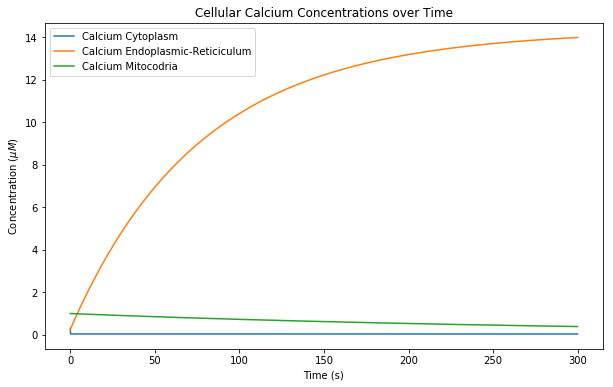

In [47]:
%matplotlib inline
plt.figure(0,figsize = (10,6))
plt.title("Cellular Calcium Concentrations over Time")
plt.xlabel('Time (s)')
plt.ylabel('Concentration ($\mu M$)')
plt_labels = ['Calcium Cytoplasm', 'Calcium Endoplasmic-Reticiculum', 'Calcium Mitocodria']
for i in range(0,len(calcium_over_time)):
    plt.plot(time_steps, calcium_over_time[i], label = plt_labels[i])
plt.legend()
plt.show()

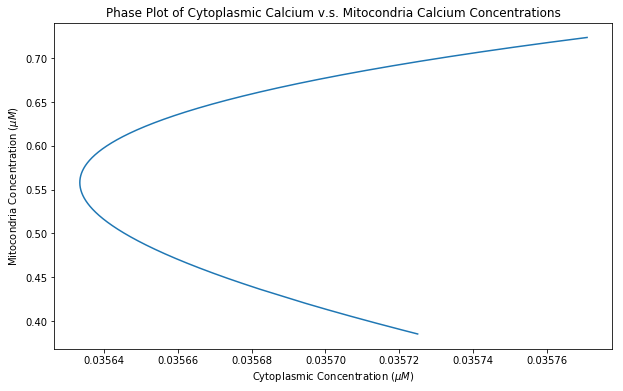

In [48]:
%matplotlib inline
plt.figure(1,figsize = (10,6))
plt.title("Phase Plot of Cytoplasmic Calcium v.s. Mitocondria Calcium Concentrations")
plt.xlabel('Cytoplasmic Concentration ($\mu M$)')
plt.ylabel('Mitocondria Concentration ($\mu M$)')
plt.plot(calcium_over_time[0][start:end], calcium_over_time[2][start:end])
plt.show()

<IPython.core.display.Javascript object>


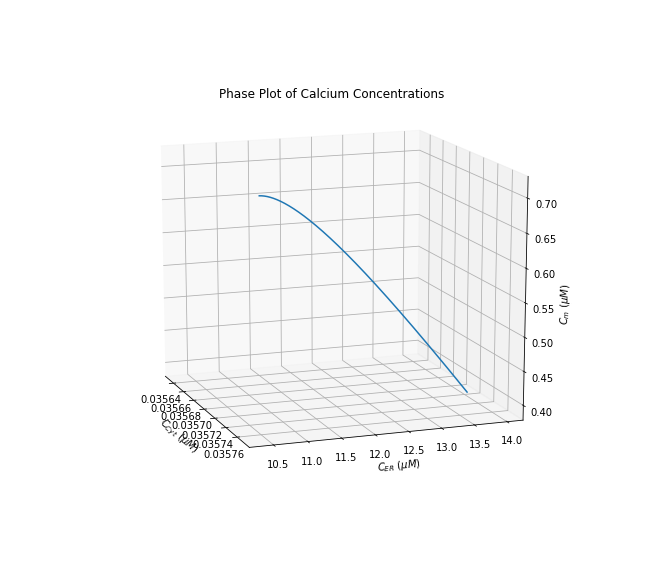

In [45]:
%matplotlib notebook
fig = plt.figure(2,figsize = (9, 8))
ax = plt.axes(projection='3d')
ax.set_xlabel('$C_{Cyt}$ ($\mu M$)')
ax.set_ylabel('$C_{ER}$ ($\mu M$)')
ax.set_zlabel('$C_m$ ($\mu M$)')
ax.plot3D(calcium_over_time[0][start:end], calcium_over_time[1][start:end], calcium_over_time[2][start:end])
plt.title('Phase Plot of Calcium Concentrations')
plt.show()

In [46]:
%matplotlib inline